<div align="right"><i>Peter Norvig, 23 Oct, 2017</i></div>

# Bike Speed versus Grade

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded all my recorded past rides longer than 20 miles as ([bikerides20.txt](bikerides20.txt)). (I started recording using 
[Strava](https://www.strava.com/athletes/575579) in mid-2013, but didn't use it across all rides until 2015). Here I parse the file:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

line = 'Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft	' # Sample line

Ride = namedtuple('Ride', 'miles, feet, kind, date, title, hours')

def parse_ride(line) -> Ride:
    "Parse a line from a Strava datafile into a `Ride`."
    kind, date, title, time, mi, ft = line.strip().split('\t')
    times = [int(t) for t in reversed(time.split(':'))]
    miles = float(mi.split()[0])
    feet  = int(ft.split()[0].replace(',', ''))
    return Ride(miles, feet, kind, date, title, hours(*times))

def hours(sec, min, hour=0): return sec / 3600 + min / 60 + hour

all_rides = {parse_ride(line) for line in open('bikerides20.txt')}

I'm interested in my "serious" rides, so I'll focus on `rides` that are at least a marathon (26 miles) in length, and for those rides collect three vectors of numbers: miles per hour, feet climbed per mile, and total miles:

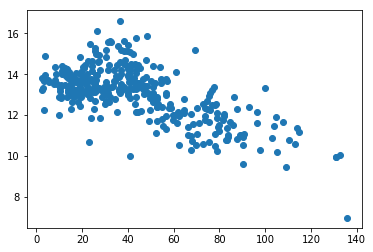

In [2]:
rides = [r for r in all_rides if r.miles > 26]
mph = [r.miles / r.hours for r in rides]
fpm = [r.feet / r.miles for r in rides]
mls = [r.miles for r in rides]

plt.scatter(fpm, mph);

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing it, it looks like a curve would be a better fit than a straight line, so I'll fit a quadratic (degree two) polynomial to the data, and make the plot prettier:

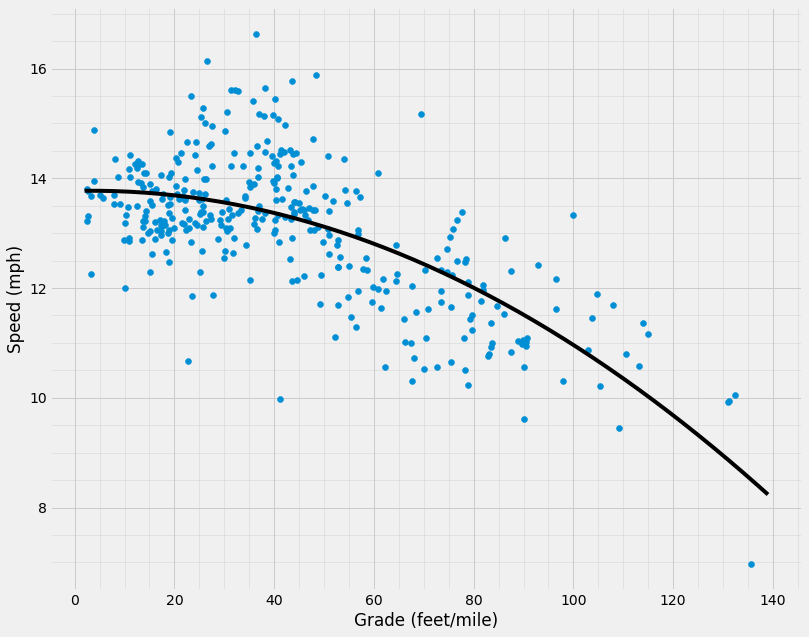

In [3]:
def poly(X, Y, n):
    "Best-fit degree-n polynomial for X, Y data."
    C = np.polyfit(X, Y, n)[::-1] # Array of coefficients, reversed
    return lambda x: sum(C[i] * x ** i for i in range(n + 1))  

def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', fit=True): 
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.style.use('fivethirtyeight')
    plt.scatter(X, Y)
    X1 = list(range(int(min(X)), int(max(X)) + 5))
    plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.minorticks_on()
    plt.grid(True, which='major')
    plt.grid(True, which='minor', alpha=0.4)
    if fit: 
        F = poly(X, Y, 2)
        plt.plot(X1, [F(x) for x in X1], 'k-')
    
show(fpm, mph)     

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But from around 40 or 50 ft/mile, speed falls off quickly, and by 140 ft/mile, I'm down near 8 mph. Note that 140 ft/mile is only 2.7% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flatish, then that's 8% grade on the up part.

# Estimating Duration

For a route with a given distance and elevation, how long will it take to ride it?

In [4]:
def duration(dist, climb, F=poly(fpm, mph, 2)):
    "Given a distance in miles and total climb in feet, return estimated time in minutes."
    return 60 * dist / F(climb / dist)

For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1); which is faster?

In [5]:
duration(15.7, 344), duration(13.5, 735)

(68.914878773787706, 62.368854685107713)

This suggests the coast route takes 7 or 8 minutes longer. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Eddington Number

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the largest integer **e** for which you have bicycled **e** or more miles on **e** different days.*

Let's calculate mine, and see how many rides I need to take to improve it. I'm pretty sure I've done at least 50 rides of 50 miles, so:

In [6]:
def eddington(distances):
    return max(e for e, d in enumerate(sorted(distances, reverse=True), 1) if d >= e)

eddington(mls)

52

So **my Eddington Number is 52**: I've done 52 rides of 52 miles or more. Let's see a plot of how far I have to go to improve this number:

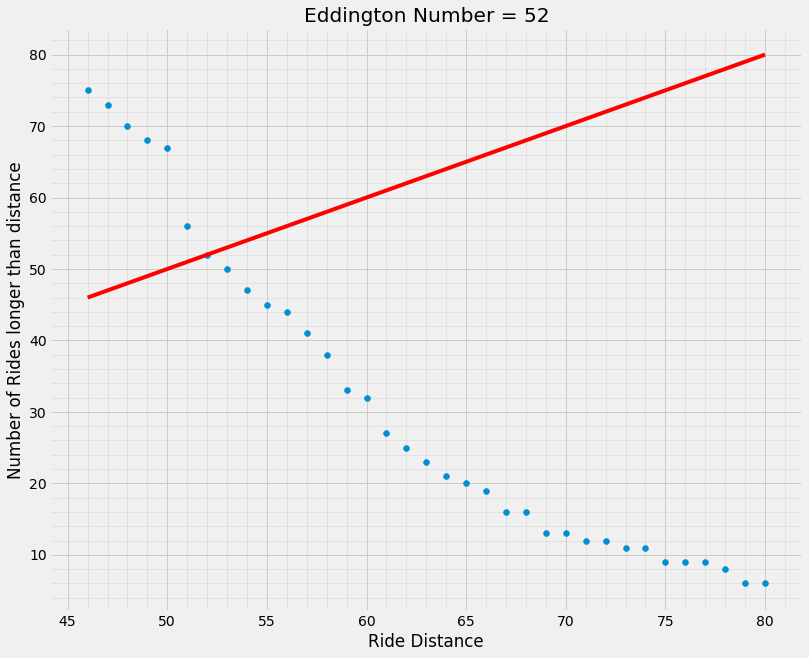

In [7]:
def edplot(distances, X):
    M = [min(X), max(X)]
    plt.plot(M, M, 'r-')
    plt.title('Eddington Number = {}'.format(eddington(distances)))
    show(X, [sum(d > x for d in distances) for x in X], fit=False,
         xlabel='Ride Distance', ylabel='Number of Rides longer than distance')
    
edplot(mls, range(46, 81))

Here the gap between the straight line and the dotted line is my Eddington gap: the lines cross at 52 so that's my Eddington Number; at 60 miles the gap is 28, so I nneed 28 60+ mile rides to get an Eddington number of 60.

# Metric Eddington Number

[Arthur Eddington](https://en.wikipedia.org/wiki/Arthur_Eddington) was born in 19th century England, so he used miles. You can get a bigger number using kilometers:

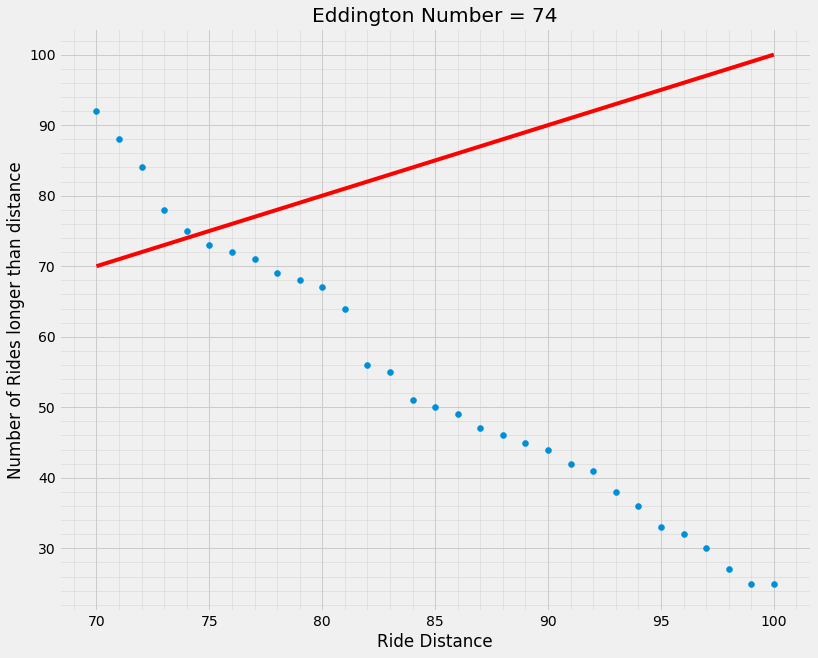

In [8]:
edplot([m * 1.60934 for m in mls], range(70, 101))

My metric Eddington Number is 74, and I only need 13 rides of 80 km (50 miles) to get to 80.

# H-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications (and indirectly by Eddington), I invented a new h-index, or hill-index:

> *Your **h-index** is the largest integer **h** for which you can persistently and repeatedly climb an **h** percent grade at **h** miles per hour.*

My h-index is 6, because I regularly climb a 6% grade at 6 miles per hour or more, but I only occasionally climb a 7% grade at 7 mph. What's yours?